# Pair Trading Algorithm

## Loading Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels
from pandas_datareader import DataReader
from datetime import datetime
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

## Getting all the data

In [2]:
def get_data(data):
    df = pd.DataFrame()
    for i in data:
        s = DataReader(i,  'yahoo', datetime(2017,1,1), datetime(2019,12,31));
        df[i] = s["Open"]
    
    return df

In [3]:
hc_companies = ['JNJ','PG','UNH','RHHBY','MRK','PFE','NVS','ABT','LLY','MDT', 'TMO','SNY',"NVO","GSK","MMM","CSV","SIEGY","CI","BDX","GE"]
sp_500 = ['MSFT','AAPL','AMZN','FB','GOOGL','JPM','JNJ','V','PG','MA','INTC','UNH','BAC','T','HD','XOM','DIS','VZ','KO','MRK']
df_hc = get_data(hc_companies)
df_sp = get_data(sp_500)

In [4]:
df_hc.head()

,JNJ,PG,UNH,RHHBY,MRK,PFE,NVS,ABT,LLY,MDT,TMO,SNY,NVO,GSK,MMM,CSV,SIEGY,CI,BDX,GE
Date,,,,,,,,,,,,,,,,,,,,
2017-01-03,115.779999,83.879997,161.130005,28.549999,59.150002,32.700001,65.313622,38.630001,73.940002,70.250000,142.389999,40.560001,36.230000,38.549999,178.830002,28.860001,60.330002,133.910004,161.949997,30.451923
2017-01-04,115.500000,84.449997,162.350006,28.940001,60.500000,33.130001,64.686378,39.060001,74.949997,70.900002,143.949997,40.790001,36.119999,38.900002,178.029999,28.660000,60.169998,136.080002,165.460007,30.528847
2017-01-05,116.000000,84.410004,161.750000,29.610001,60.220001,33.369999,66.039429,39.240002,74.930000,71.480003,145.380005,41.279999,36.790001,39.200001,178.259995,28.450001,60.195000,139.080002,163.809998,30.355770
2017-01-06,116.669998,84.940002,161.750000,29.660000,60.090000,33.660000,65.922935,39.700001,75.459999,71.139999,145.279999,40.130001,36.759998,39.360001,177.289993,28.320000,60.869999,141.000000,165.289993,30.365385
2017-01-09,116.349998,84.059998,162.000000,29.650000,60.299999,33.430000,66.021507,40.790001,75.669998,73.300003,147.009995,40.900002,36.389999,39.230000,178.369995,28.040001,61.189999,141.309998,168.229996,30.423077


In [5]:
df_sp.head()

,MSFT,AAPL,AMZN,FB,GOOGL,JPM,JNJ,V,PG,MA,INTC,UNH,BAC,T,HD,XOM,DIS,VZ,KO,MRK
Date,,,,,,,,,,,,,,,,,,,,
2017-01-03,62.790001,115.800003,757.919983,116.029999,800.619995,87.339996,115.779999,78.760002,83.879997,104.410004,36.610001,161.130005,22.600000,42.689999,135.100006,90.940002,105.300003,53.959999,41.500000,59.150002
2017-01-04,62.480000,115.849998,758.390015,117.550003,809.890015,86.959999,115.500000,79.440002,84.449997,105.339996,36.709999,162.350006,22.719999,42.939999,134.339996,91.120003,106.639999,54.549999,41.880001,60.500000
2017-01-05,62.189999,115.919998,761.549988,118.860001,807.500000,86.809998,116.000000,80.339996,84.410004,107.050003,36.450001,161.750000,22.820000,42.849998,134.979996,90.190002,107.169998,54.779999,41.660000,60.220001
2017-01-06,62.299999,116.779999,782.359985,120.980003,814.989990,86.389999,116.669998,81.300003,84.940002,107.320000,36.590000,161.750000,22.780001,41.980000,133.970001,88.790001,108.019997,53.669998,41.700001,60.090000
2017-01-09,62.759998,117.949997,798.000000,123.550003,826.369995,85.730003,116.349998,82.279999,84.059998,107.760002,36.480000,162.000000,22.510000,41.290001,133.220001,88.220001,108.580002,53.220001,41.230000,60.299999


## Test for Cointegration Pairs

In [6]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.08:
                pairs.append((keys[i], keys[j]))
                
    return score_matrix, pvalue_matrix, pairs

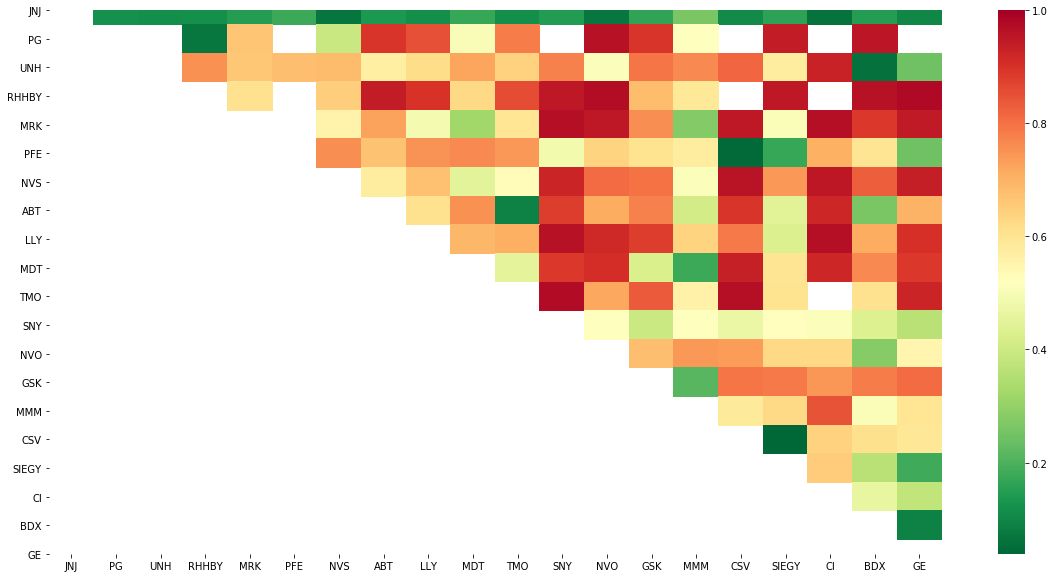

[('JNJ', 'NVS'), ('JNJ', 'NVO'), ('JNJ', 'CI'), ('PG', 'RHHBY'), ('UNH', 'BDX'), ('PFE', 'CSV'), ('CSV', 'SIEGY')]


In [7]:
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks
scores, pvalues, pairs = find_cointegrated_pairs(df_hc)
plt.figure(figsize=(20,10))
m = [0,0.2,0.4,0.6,0.8,1]
sns.heatmap(pvalues, xticklabels=hc_companies, 
                yticklabels=hc_companies, cmap='RdYlGn_r', 
                mask = (pvalues >= 0.98))

plt.show()
print(pairs)

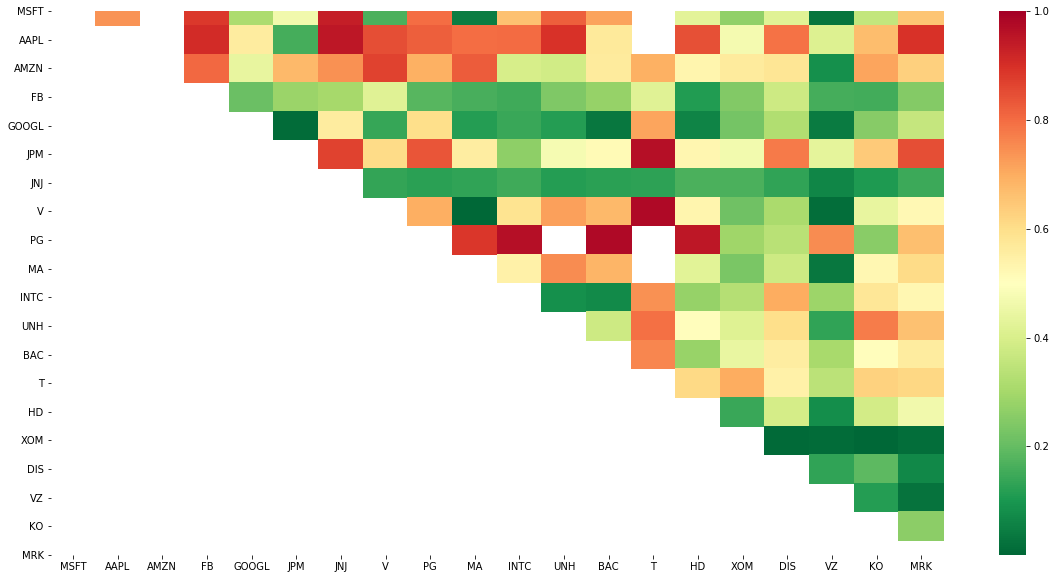

[('MSFT', 'MA'), ('MSFT', 'VZ'), ('GOOGL', 'JPM'), ('GOOGL', 'BAC'), ('GOOGL', 'HD'), ('GOOGL', 'VZ'), ('JNJ', 'VZ'), ('V', 'MA'), ('V', 'VZ'), ('MA', 'VZ'), ('INTC', 'BAC'), ('XOM', 'DIS'), ('XOM', 'VZ'), ('XOM', 'KO'), ('XOM', 'MRK'), ('DIS', 'MRK'), ('VZ', 'MRK')]


In [8]:
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks
scores, pvalues, pairs = find_cointegrated_pairs(df_sp)
plt.figure(figsize=(20,10))
m = [0,0.2,0.4,0.6,0.8,1]
sns.heatmap(pvalues, xticklabels=sp_500, 
                yticklabels=sp_500, cmap='RdYlGn_r', 
                mask = (pvalues >= 0.98))

plt.show()
print(pairs)

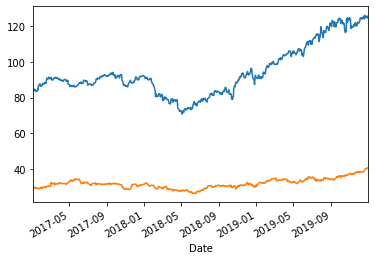

In [9]:
S1 = df_hc['PG']
S2 = df_hc['RHHBY']
S1.plot()
S2.plot()

## Plot of Price Ratio between PG and RHHBY from 2017–2019

0.07108750483386062


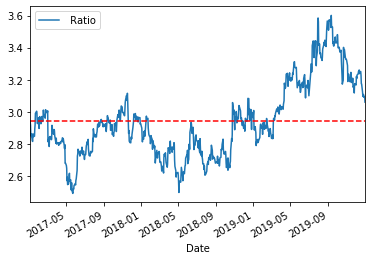

In [10]:
S1 = df_hc['PG']
S2 = df_hc['RHHBY']
score, pvalue, _ = coint(S1, S2)
print(pvalue)
ratios = S1 / S2
ratios.plot()
plt.axhline(ratios.mean(), color='red', linestyle='--')
plt.legend([' Ratio'])
plt.show()

## Assumption: Normalizing our ratio by treating it as a z-score

In [11]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

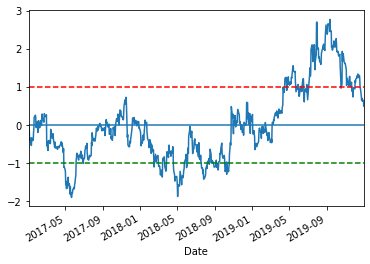

In [12]:
zscore(ratios).plot()
plt.axhline(zscore(ratios).mean())
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.show()

## Test and Train Data set

In [13]:
train_data, test_data = ratios[:int(len(ratios)*0.8)], ratios[int(len(ratios)*0.8):]

## Feature Engineering
### 1. 30 day Moving Average of Ratio: Measure of rolling mean
### 2. 5 day Moving Average of Ratio: Measure of current value of mean
### 3. 30 day Standard Deviation
### 4. z score: (5d MA — 30d MA) /30d SD

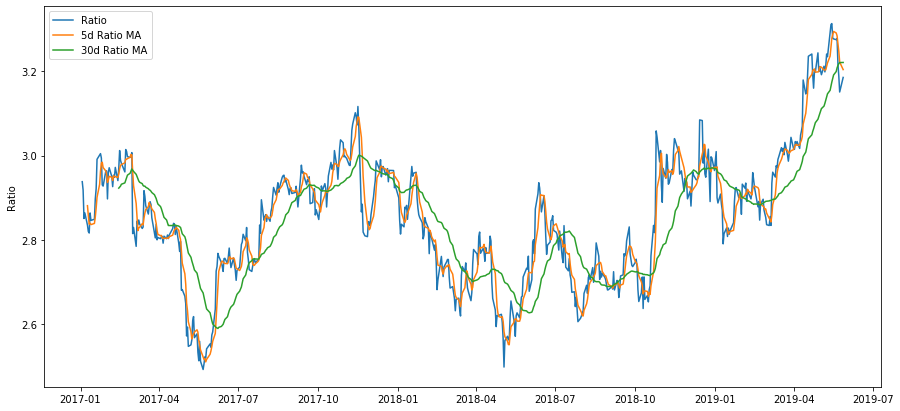

In [14]:
ratios_mavg5 = train_data.rolling(window=5,
                               center=False).mean()
ratios_mavg30 = train_data.rolling(window=30,
                               center=False).mean()
std_30 = train_data.rolling(window=30,
                        center=False).std()
zscore_30_5 = (ratios_mavg5 - ratios_mavg30)/std_30
plt.figure(figsize=(15,7))
plt.plot(train_data.index, train_data.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg30.index, ratios_mavg30.values)
plt.legend(['Ratio','5d Ratio MA', '30d Ratio MA'])
plt.ylabel('Ratio')
plt.show()

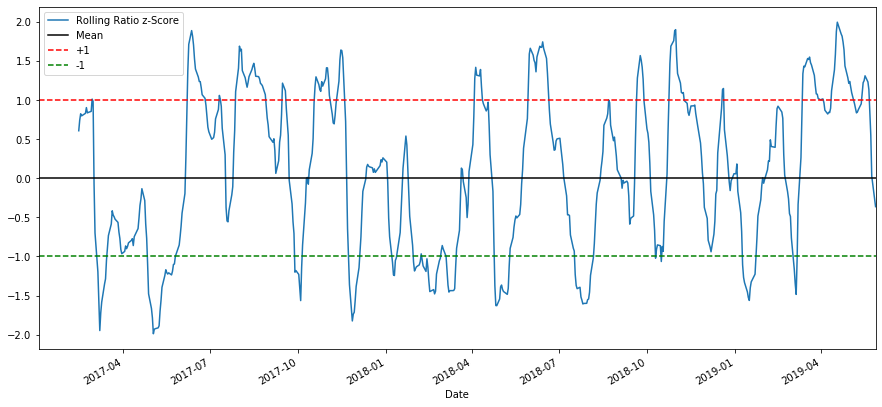

In [15]:
plt.figure(figsize=(15,7))
zscore_30_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

## Plot the ratios and buy and sell signals from z score

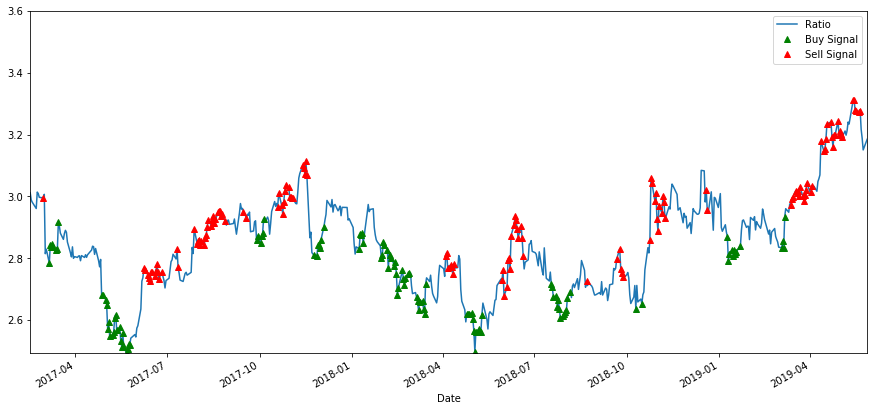

In [16]:
plt.figure(figsize=(15,7))
train_data[30:].plot()
buy = train_data.copy()
sell = train_data.copy()
buy[zscore_30_5>-1] = 0
sell[zscore_30_5<1] = 0
buy[30:].plot(color='g', linestyle='None', marker='^')
sell[30:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(["Ratio", "Buy Signal", "Sell Signal"])
plt.show()

## Plot the prices and buy and sell signals from z score

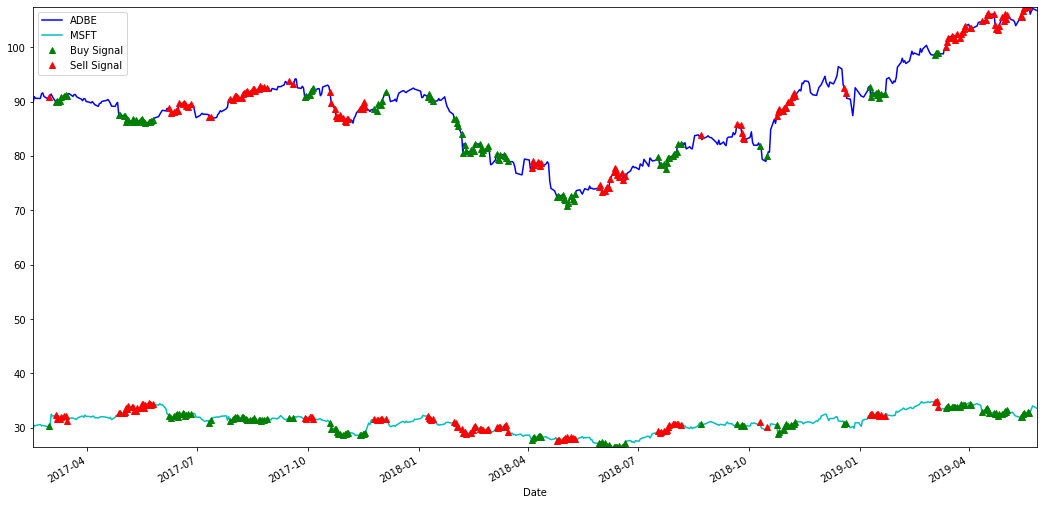

In [17]:
plt.figure(figsize=(18,9))
S1 = df_hc['PG'].iloc[:603]
S2 = df_hc['RHHBY'].iloc[:603]
S1[30:].plot(color='b')
S2[30:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()
# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]
buyR[30:].plot(color='g', linestyle='None', marker='^')
sellR[30:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))
plt.legend(['ADBE','MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()

##  Using a simple trading strategy, calculating net profit

In [18]:
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            
            
    return money

In [19]:
train_money = trade(df_hc['PG'].iloc[:603], df_hc['RHHBY'].iloc[:603], 5, 30)

Exit pos 0.0 2.9699629595846138 0 0
Exit pos 0.0 3.011737038152346 0 0
Selling Ratio 0.0 2.9960448605378622 -1 2.9960448605378622
Exit pos 5.881578753066805 2.8149060083065707 0 0
Exit pos 5.881578753066805 2.829442908183576 0 0
Buying Ratio 5.881578753066805 2.784696492841888 1 -2.784696492841888
Buying Ratio 5.881578753066805 2.8444303524947534 2 -5.629126845336641
Buying Ratio 5.881578753066805 2.8361687867742256 3 -8.465295632110866
Buying Ratio 5.881578753066805 2.8471257051195624 4 -11.312421337230429
Buying Ratio 5.881578753066805 2.8375000953674316 5 -14.14992143259786
Buying Ratio 5.881578753066805 2.82707234234262 6 -16.976993774940482
Buying Ratio 5.881578753066805 2.8306450801825895 7 -19.80763885512307
Buying Ratio 5.881578753066805 2.9166665953448714 8 -22.72430545046794
Exit pos 16.21210454233264 2.881222356890411 0 0
Exit pos 16.21210454233264 2.8612770199715416 0 0
Exit pos 16.21210454233264 2.8801262099178517 0 0
Exit pos 16.21210454233264 2.8904715770035705 0 0
Exit 

In [20]:
test_money = trade(df_hc['PG'].iloc[603:], df_hc['RHHBY'].iloc[603:], 5, 30)

Selling Ratio 0.0 3.248210652539291 -1 3.248210652539291
Selling Ratio 0.0 3.2745608372244126 -2 6.522771489763704
Selling Ratio 0.0 3.413225791281487 -3 9.935997281045191
Selling Ratio 0.0 3.442117817659983 -4 13.378115098705173
Selling Ratio 0.0 3.424681801873729 -5 16.8027969005789
Selling Ratio 0.0 3.3968301847245055 -6 20.199627085303405
Selling Ratio 0.0 3.338077237481134 -7 23.53770432278454
Selling Ratio 0.0 3.4405719705087647 -8 26.978276293293302
Selling Ratio 0.0 3.4156769558534874 -9 30.39395324914679
Selling Ratio 0.0 3.44272528959238 -10 33.83667853873917
Selling Ratio 0.0 3.3894015467978407 -11 37.22608008553701
Selling Ratio 0.0 3.287525917386324 -12 40.51360600292334
Selling Ratio 0.0 3.5847813011728538 -13 44.09838730409619
Selling Ratio 0.0 3.5603603686166108 -14 47.658747672712806
Selling Ratio 0.0 3.4157138684093864 -15 51.07446154112219
Selling Ratio 0.0 3.4224646994283803 -16 54.49692624055057
Selling Ratio 0.0 3.361431437730119 -17 57.85835767828069
Exit pos 20.

In [21]:
print("Profit from training dataset: ", train_money)
print("Profit from testing dataset: ", test_money)

Profit from training dataset:  135.8527961383856
Profit from testing dataset:  111.05874684841848
